In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


In [2]:
building_damage_assessment = pd.read_csv("../csv_files/csv_building_damage_assessment.csv",low_memory=False)
name_mapping = pd.read_csv("../csv_files/ward_vdcmun_district_name_mapping.csv",low_memory=False)


In [3]:
# Create district_id_name_dict
district_id_name_dict = name_mapping.set_index('district_id')['district_name'].to_dict()


In [4]:
duplicates = name_mapping[name_mapping.duplicated(subset='vdcmun_id', keep=False)]
name_mapping = name_mapping.drop_duplicates(subset='vdcmun_id')
name_mapping = name_mapping.groupby('vdcmun_id').agg({
    'vdcmun_name': 'first',
    'district_name': 'first'
}).reset_index()
vdcmun_id_name_dict = name_mapping.set_index('vdcmun_id')[['vdcmun_name', 'district_name']].to_dict('index')



In [5]:
# main_df_columns = building_damage_assessment.iloc[:, :54]
main_df_columns = building_damage_assessment.copy()

In [6]:
# Map vdcmun_id to vdcmun_name and district_name
main_df_columns['vdcmun_name'] = main_df_columns['vdcmun_id'].map(lambda x: vdcmun_id_name_dict[x]['vdcmun_name'])
main_df_columns['district_name'] = main_df_columns['vdcmun_id'].map(lambda x: vdcmun_id_name_dict[x]['district_name'])

# Reorder columns
cols = list(main_df_columns.columns)
cols.insert(cols.index('vdcmun_id'), cols.pop(cols.index('vdcmun_name')))
cols.insert(cols.index('district_id'), cols.pop(cols.index('district_name')))
main_df_columns = main_df_columns[cols]

In [7]:
from scipy.stats import chi2_contingency
target_column = 'damage_grade'
cramerV_list = []
processed_df = main_df_columns.iloc[:, :6]
# for i in range(6, 55):
for i in range(6, len(main_df_columns.columns)-1):
    entry_column = main_df_columns.columns[i]
    contingency_table = pd.crosstab(main_df_columns[entry_column], main_df_columns[target_column])

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()# Total number of observations
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    if cramers_v > 0.1:
        cramerV_list.append(cramers_v)
        print("Cramér's V:", cramers_v)
        print("Column name is: ", main_df_columns.columns[i])
        processed_df = pd.concat([processed_df, main_df_columns.iloc[:, i]], axis=1)
processed_df = pd.concat([processed_df, main_df_columns[target_column]], axis=1)

Cramér's V: 0.5618371122498683
Column name is:  damage_overall_collapse
Cramér's V: 0.2851951023763733
Column name is:  damage_overall_leaning
Cramér's V: 0.1042170428883672
Column name is:  damage_overall_adjacent_building_risk
Cramér's V: 0.25243262743853423
Column name is:  damage_foundation_severe
Cramér's V: 0.12954995401876135
Column name is:  damage_foundation_moderate
Cramér's V: 0.22690109928414273
Column name is:  damage_roof_severe
Cramér's V: 0.1601800176447552
Column name is:  damage_roof_moderate
Cramér's V: 0.1325611859472195
Column name is:  damage_roof_insignificant
Cramér's V: 0.2520240002737159
Column name is:  damage_corner_separation_severe
Cramér's V: 0.17510153232897083
Column name is:  damage_corner_separation_moderate
Cramér's V: 0.11620196828457742
Column name is:  damage_corner_separation_insignificant
Cramér's V: 0.23537221388176963
Column name is:  damage_diagonal_cracking_severe
Cramér's V: 0.1997205539561868
Column name is:  damage_diagonal_cracking_moder

In [8]:
processed_df.shape

(762106, 73)

# Now we do some preprocessing 

### number of missing values in each column

In [9]:
# we want the number of non null values in each column
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 73 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   building_id                                           762106 non-null  int64  
 1   district_name                                         762106 non-null  object 
 2   district_id                                           762106 non-null  int64  
 3   vdcmun_name                                           762106 non-null  object 
 4   vdcmun_id                                             762106 non-null  int64  
 5   ward_id                                               762106 non-null  int64  
 6   damage_overall_collapse                               428934 non-null  object 
 7   damage_overall_leaning                                270616 non-null  object 
 8   damage_overall_adjacent_building_risk       

### we will only keep those columns that have data more than a threshold

In [10]:
# we will only keep those columns that have data more than a threshold
def dropSelectedColumns(df, threshold):
    df = df.dropna(thresh=threshold*len(df), axis=1)
    return df

In [11]:
col_dropped_df = dropSelectedColumns(processed_df, 0.2)
col_dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762106 entries, 0 to 762105
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   building_id                                 762106 non-null  int64  
 1   district_name                               762106 non-null  object 
 2   district_id                                 762106 non-null  int64  
 3   vdcmun_name                                 762106 non-null  object 
 4   vdcmun_id                                   762106 non-null  int64  
 5   ward_id                                     762106 non-null  int64  
 6   damage_overall_collapse                     428934 non-null  object 
 7   damage_overall_leaning                      270616 non-null  object 
 8   damage_roof_insignificant                   181707 non-null  object 
 9   damage_corner_separation_severe             157789 non-null  object 
 

In [12]:
# from column "has_repair_started" to "has_geotechnical_risk_fault_crack", if we have np.nan, make them as 0
def fillNanWithZero(df):
    # Select float64 columns
    float_cols = df.select_dtypes(include=[np.float64]).columns
    # Use .loc to assign values explicitly
    df.loc[:, float_cols] = df[float_cols].fillna(0)
    return df

# Example usage
filled_Nan_df = fillNanWithZero(col_dropped_df)

In [13]:
# remove the rows in which damage_grade is null
def removeNullRows(df):
    df = df.dropna(subset=['damage_grade'])
    return
filled_Nan_df = filled_Nan_df.dropna(subset=['damage_grade'])

In [14]:
filled_Nan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762094 entries, 0 to 762105
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   building_id                                 762094 non-null  int64  
 1   district_name                               762094 non-null  object 
 2   district_id                                 762094 non-null  int64  
 3   vdcmun_name                                 762094 non-null  object 
 4   vdcmun_id                                   762094 non-null  int64  
 5   ward_id                                     762094 non-null  int64  
 6   damage_overall_collapse                     428931 non-null  object 
 7   damage_overall_leaning                      270616 non-null  object 
 8   damage_roof_insignificant                   181707 non-null  object 
 9   damage_corner_separation_severe             157789 non-null  object 
 10  d

In [15]:
columns_to_fill = filled_Nan_df.columns[6:18]

# Fill missing values with a default value (e.g., 'Unknown' for object columns)
for col in columns_to_fill:
    # Get the mode of the column
    mode_value = filled_Nan_df[col].mode()[0]  # Get the first mode value (if there are multiple modes)

    # Fill NaN values with the mode value
    filled_Nan_df.loc[:, col] = filled_Nan_df[col].fillna(mode_value)


In [16]:
# for each column in columns_to_fill, i want to get the number of counts of unique items in that column
def getUniqueItemsCount(df, columns):
    for col in columns:
        print(df[col].value_counts())
        print("\n")
    return

In [17]:
filled_Nan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762094 entries, 0 to 762105
Data columns (total 36 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   building_id                                 762094 non-null  int64  
 1   district_name                               762094 non-null  object 
 2   district_id                                 762094 non-null  int64  
 3   vdcmun_name                                 762094 non-null  object 
 4   vdcmun_id                                   762094 non-null  int64  
 5   ward_id                                     762094 non-null  int64  
 6   damage_overall_collapse                     762094 non-null  object 
 7   damage_overall_leaning                      762094 non-null  object 
 8   damage_roof_insignificant                   762094 non-null  object 
 9   damage_corner_separation_severe             762094 non-null  object 
 10  d

In [18]:
df_damage = filled_Nan_df.copy()

In [19]:
# edit the df_damage so that all except last column remain
df_damage = df_damage.iloc[:, :-1]

In [20]:
temp_df = df_damage.copy()

In [21]:
# Define the scoring dictionary
damage_scores = {
    "Severe-Extreme": 100,
    "Severe-Extreme-(>2/3)": 90,
    "Severe-Extreme-(<1/3)": 80,
    "Moderate-Heavy": 75,
    "Moderate-Heavy-(>2/3)": 65,
    "Moderate-Heavy-(<1/3)": 55,
    "Insignificant/light": 25,
    "Grade 5": 90,
    "Grade 4": 70,
    "Grade 3": 50,
    "Grade 2": 30,
    "Grade 1": 10
}


In [22]:
# Map damage_grade to numerical scores
df_damage['damage_score'] = df_damage['damage_grade'].map(damage_scores)


In [23]:

# Binary damage columns (starting with 'has_')
binary_columns = [col for col in df_damage.columns if col.startswith("has_")]


In [24]:

# Calculate total binary damage for each building
df_damage['binary_damage_sum'] = df_damage[binary_columns].sum(axis=1)


In [25]:

# Aggregate by vdcmun_name
vdcmun_group = df_damage.groupby('vdcmun_name').agg({
    'damage_score': 'sum',
    'binary_damage_sum': 'sum',
    'building_id': 'count'  # To normalize scores
}).reset_index()


In [26]:

# Calculate damage percentage for vdcmun_name
vdcmun_group['damage_percent_vdcmun_name'] = (
    (vdcmun_group['damage_score'] + vdcmun_group['binary_damage_sum']) /
    (vdcmun_group['building_id'] * (100 + len(binary_columns)))
) * 100


In [27]:

# Map back to the original dataframe
df_damage = df_damage.merge(
    vdcmun_group[['vdcmun_name', 'damage_percent_vdcmun_name']],
    on='vdcmun_name',
    how='left'
)


In [28]:

# Repeat for district_name
district_group = df_damage.groupby('district_name').agg({
    'damage_score': 'sum',
    'binary_damage_sum': 'sum',
    'building_id': 'count'
}).reset_index()

district_group['damage_percent_district_name'] = (
    (district_group['damage_score'] + district_group['binary_damage_sum']) /
    (district_group['building_id'] * (100 + len(binary_columns)))
) * 100

df_damage = df_damage.merge(
    district_group[['district_name', 'damage_percent_district_name']],
    on='district_name',
    how='left'
)

C:\Users\offic\AppData\Local\Temp\ipykernel_29268\2096754886.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='damage_percent_vdcmun_name', y='vdcmun_name', data=df_damage, palette='coolwarm')


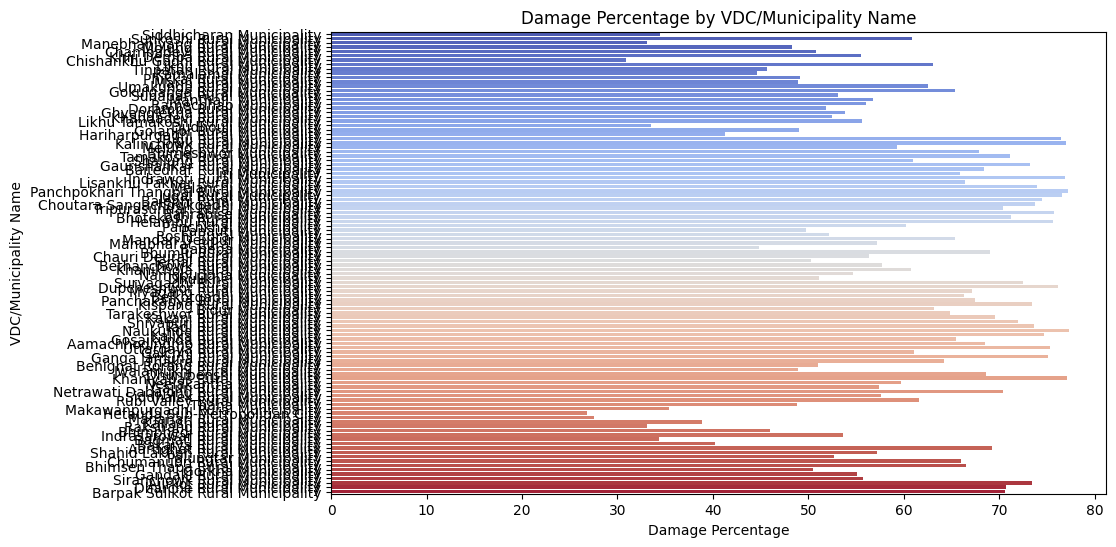

In [29]:
# Plotting damage percentages for each vdcmun_name
plt.figure(figsize=(10, 6))
sns.barplot(x='damage_percent_vdcmun_name', y='vdcmun_name', data=df_damage, palette='coolwarm')
plt.title('Damage Percentage by VDC/Municipality Name')
plt.xlabel('Damage Percentage')
plt.ylabel('VDC/Municipality Name')
plt.show()


C:\Users\offic\AppData\Local\Temp\ipykernel_29268\2122742921.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='damage_percent_district_name', y='district_name', data=df_damage, palette='coolwarm')


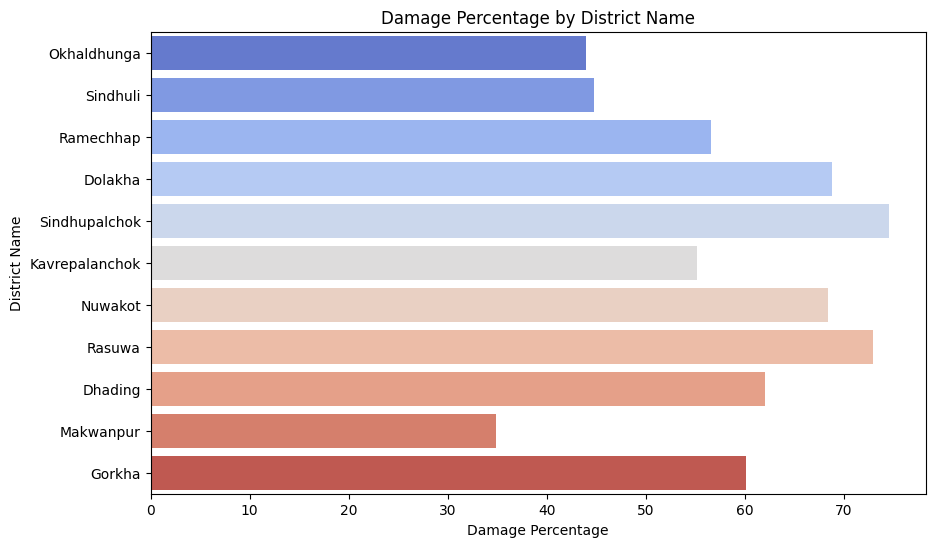

In [30]:

# Plotting damage percentages for each district_name
plt.figure(figsize=(10, 6))
sns.barplot(x='damage_percent_district_name', y='district_name', data=df_damage, palette='coolwarm')
plt.title('Damage Percentage by District Name')
plt.xlabel('Damage Percentage')
plt.ylabel('District Name')
plt.show()

In [31]:
# convert them to json
vdcmun_group_json = vdcmun_group[['vdcmun_name', 'damage_percent_vdcmun_name']].to_json(orient='records')
district_group_json = district_group[['district_name', 'damage_percent_district_name']].to_json(orient='records')
